## Import all the necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

### Exploratory Data Analysis

In [2]:
credit = pd.read_excel('CreditCardDataset.xlsx')
credit.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
1,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
2,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
3,11,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,...,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50,0
4,12,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,...,0.499625,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,15.99,0


In [3]:
credit.shape

(57355, 31)

In [4]:
credit.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57355 entries, 0 to 57354
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    57355 non-null  int64  
 1   V1      57355 non-null  float64
 2   V2      57355 non-null  float64
 3   V3      57355 non-null  float64
 4   V4      57355 non-null  float64
 5   V5      57355 non-null  float64
 6   V6      57355 non-null  float64
 7   V7      57355 non-null  float64
 8   V8      57355 non-null  float64
 9   V9      57355 non-null  float64
 10  V10     57355 non-null  float64
 11  V11     57355 non-null  float64
 12  V12     57355 non-null  float64
 13  V13     57355 non-null  float64
 14  V14     57355 non-null  float64
 15  V15     57355 non-null  float64
 16  V16     57355 non-null  float64
 17  V17     57355 non-null  float64
 18  V18     57355 non-null  float64
 19  V19     57355 non-null  float64
 20  V20     57355 non-null  float64
 21  V21     57355 non-null  float64
 22

## About the Dataset:

We have a dataset which contains transactions made by credit cards in September 2013 by European cardholders. We have 57,355 rows and 31 columns. All the columns we have are in numeric form which was obtained after PCA transformation. Due to confidentiality issues, the dataset doesnot have the original features and more background information about the data. 

Features V1, V2,...., V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. The feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The 'Amount' is the transaction amount which occured. Feature 'Class' which is our target variable is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Descriptive Analysis

In [6]:
credit.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,57355.0,94577.357074,47505.713234,2.000000,53943.500000,84641.000000,139140.000000,172777.000000
V1,57355.0,-0.029092,2.061391,-36.802320,-0.927615,0.015980,1.314129,2.454930
V2,57355.0,0.030156,1.711228,-63.344698,-0.588747,0.071801,0.815413,22.057729
V3,57355.0,-0.055749,1.733364,-48.325589,-0.922554,0.168619,1.019384,3.940337
V4,57355.0,0.035521,1.484621,-5.519697,-0.839400,-0.005637,0.764271,16.715537
V5,57355.0,-0.022664,1.508300,-113.743307,-0.692157,-0.055913,0.607021,28.762671
V6,57355.0,-0.006869,1.361819,-19.996349,-0.774796,-0.276163,0.387408,73.301626
V7,57355.0,-0.032448,1.504317,-43.557242,-0.558211,0.035797,0.562758,120.589494
V8,57355.0,0.006142,1.334058,-73.216718,-0.207145,0.024380,0.333358,20.007208
V9,57355.0,-0.017667,1.131679,-13.434066,-0.651869,-0.053373,0.599522,10.348407


> Most of our features are in small values and some are in negative values also except time and amount. However, this can be changed in the feature scaling process.

## Data Cleaning:

In [7]:
credit.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
credit.duplicated().sum()

93

In [9]:
#removing the duplicate values form the dataset

credit.drop_duplicates(inplace = True)
credit.shape

(57262, 31)

> The dataset doesn't have any missing values. However, it does contain some duplicate values. We will be removing them as they do not add any additional value to our model in the learning process and can make our model slow.


### Looking into the target variable i.e., Class feature

In [10]:
credit['Class'].value_counts()

0    56789
1      473
Name: Class, dtype: int64

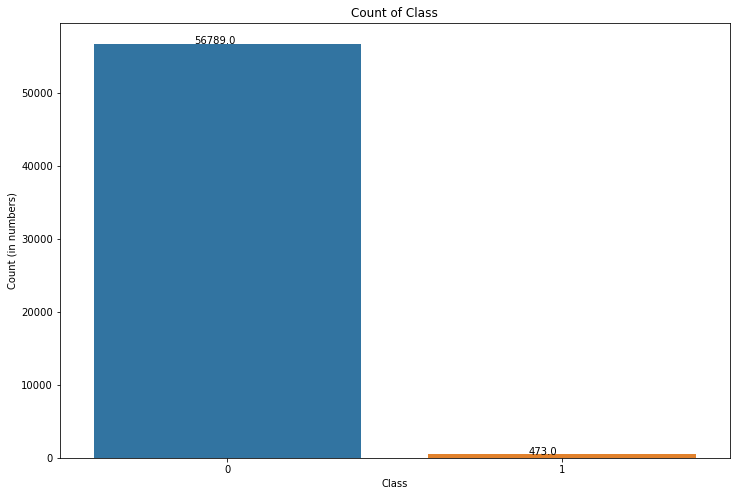

In [11]:
    
plt.figure(figsize=(12,8))
ax = sns.countplot(x='Class', data=credit)
plt.title('Count of Class')
plt.xlabel('Class')
plt.ylabel('Count (in numbers)')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.3, p.get_height()+6))

We can clearly see that, our classes are imbalanced. So, we need to handle them as well. We can either equally divided i.e, stratify the data or oversample the lower class or undersampling the high class feature which is 1 in our case. We will be using stratify technique for the balancing of the data. 

## Outlier Handling:

Outliers are some of the hardest problem to resolve during data processing. Because, if there is large no. or high outliers, we tend to deviate from our true result. So, we need to remove them.

However, removing them haphazard will cause a lot of data points to be removed from our dataset. We need to maintain a balance between removing the data point and keeping them within a certain range. Thats why the process is usually refered as outlier handling rather than outlier removel

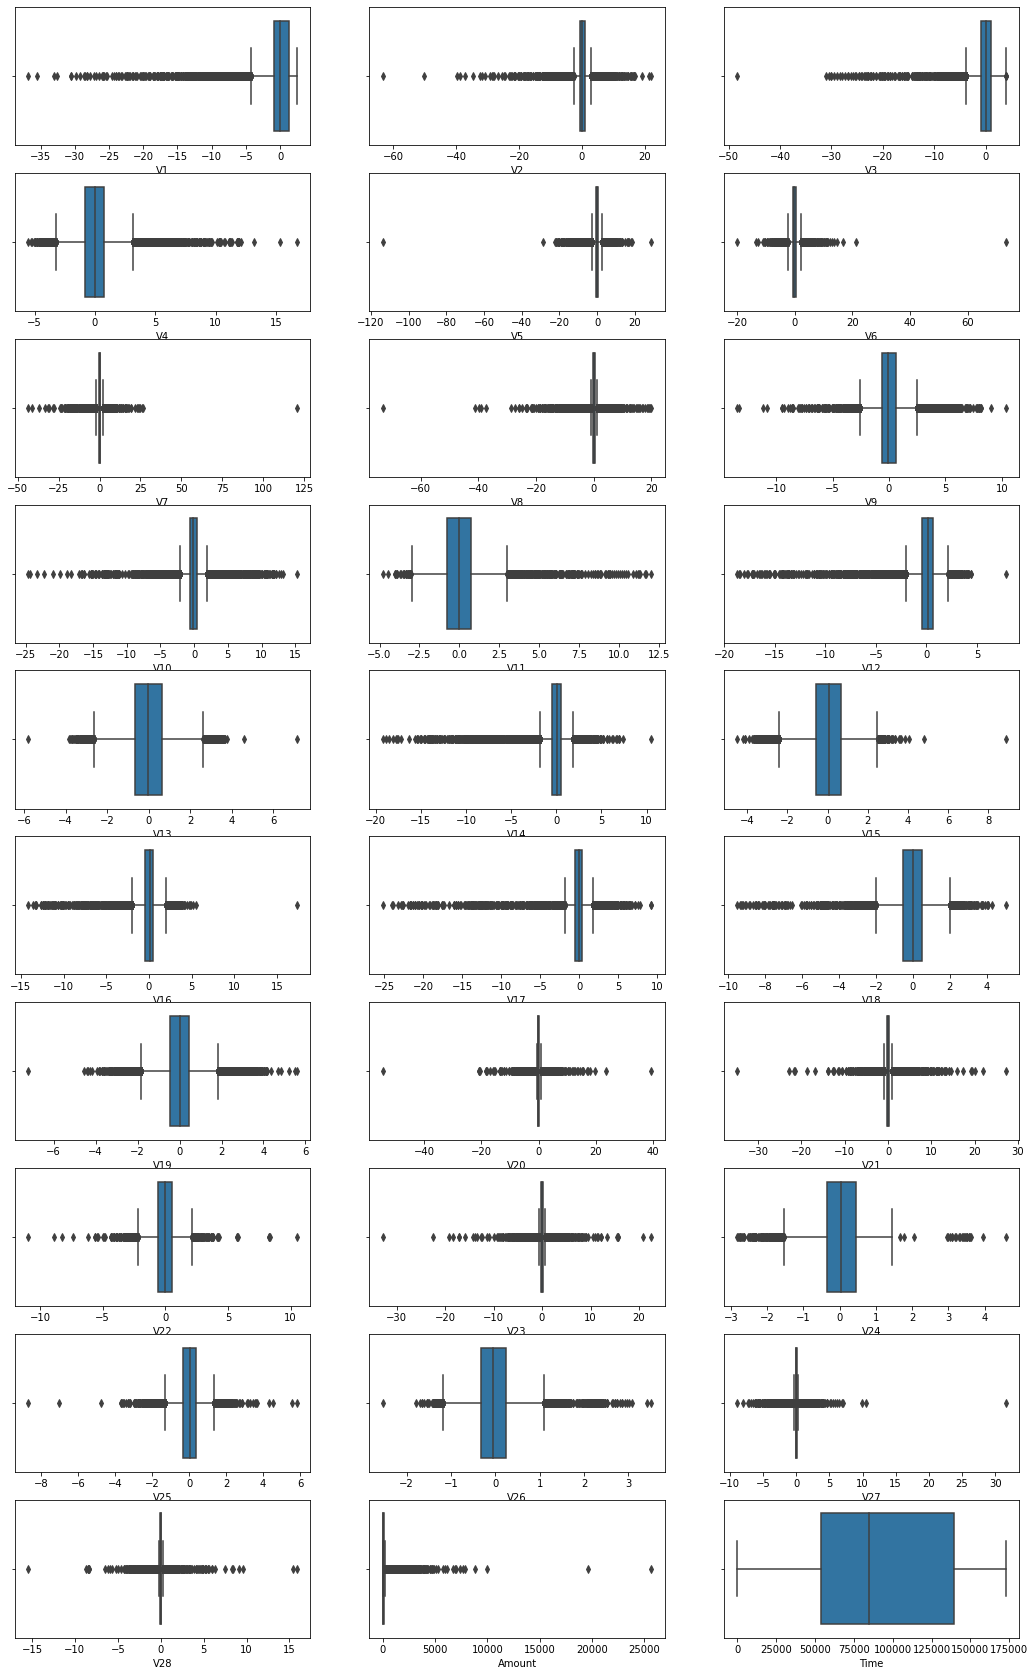

In [12]:
count = 0
credit_cols= [col_name for col_name in credit.columns if credit[col_name].dtype in ["float"]]
credit_cols.append("Time")

fig, ax = plt.subplots(nrows=10, ncols=3,figsize=(18,30))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.boxplot(data=credit,x = credit_cols[count],ax=ax[i][j])
        count +=1

> As, we can see that, we have a lot of outliers except in Time feature. We cannot remove/handle the outliers by different fashion. Here, we are doing it with the Z score way. 

In [13]:
from scipy.stats import zscore

z=np.abs(zscore(credit))
threshold=2.75
np.where(z>threshold)

credit_outlier_removed=credit[(z<threshold).all(axis=1)].reset_index()
credit_outlier_removed.drop(['index'],axis=1,inplace=True)
credit_outlier_removed.shape

(47827, 31)

In [14]:
57355 - 47827

9528

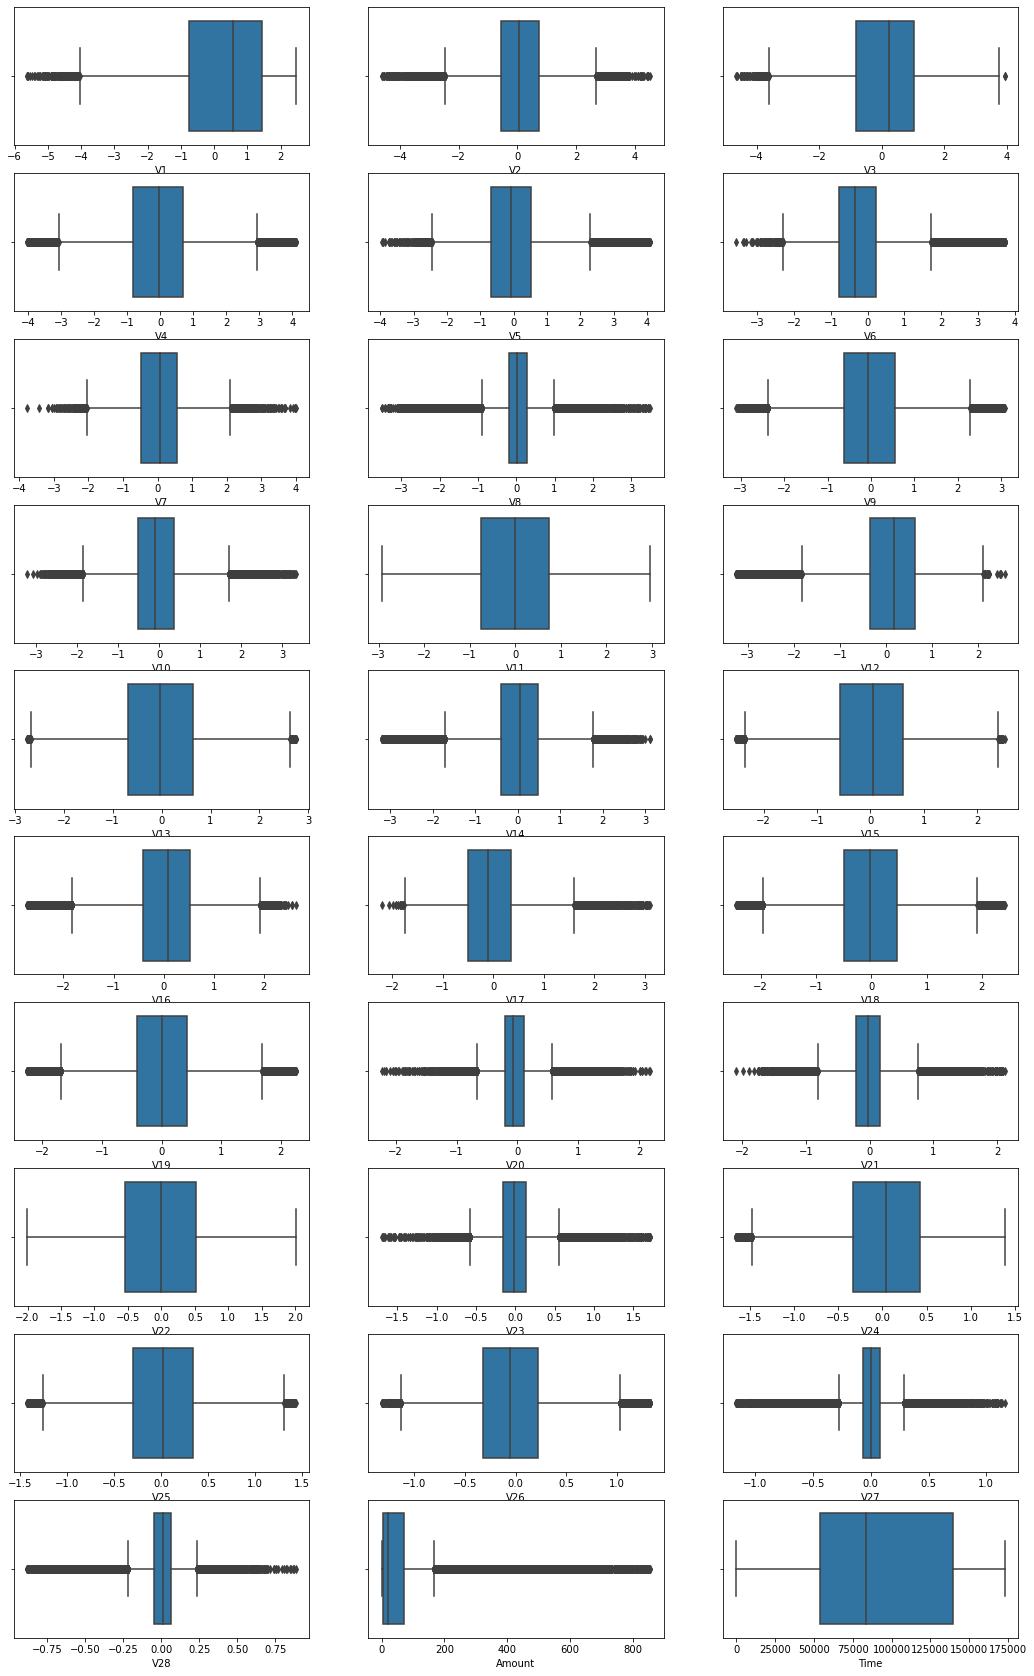

In [15]:
count = 0

fig, ax = plt.subplots(nrows=10, ncols=3,figsize=(18,30))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.boxplot(data=credit_outlier_removed,x = credit_cols[count],ax=ax[i][j])
        count +=1

> Here, we can see that, there is some outliers still in the data, but we have to ignore it. And we have lost 9528 of data from this procedure. But, moving forward with this outlier removed data lets see, how it has affected our classes.

In [16]:
credit_outlier_removed['Class'].value_counts()

0    47827
Name: Class, dtype: int64

> By outlier removal process, we have also removed all the data which was related to class 0 which is unaccaptable. So, for this reason, we cannot used the outlier removed dataset and we are going to use the orginal dataset.

## Check the distribution of data using histograms

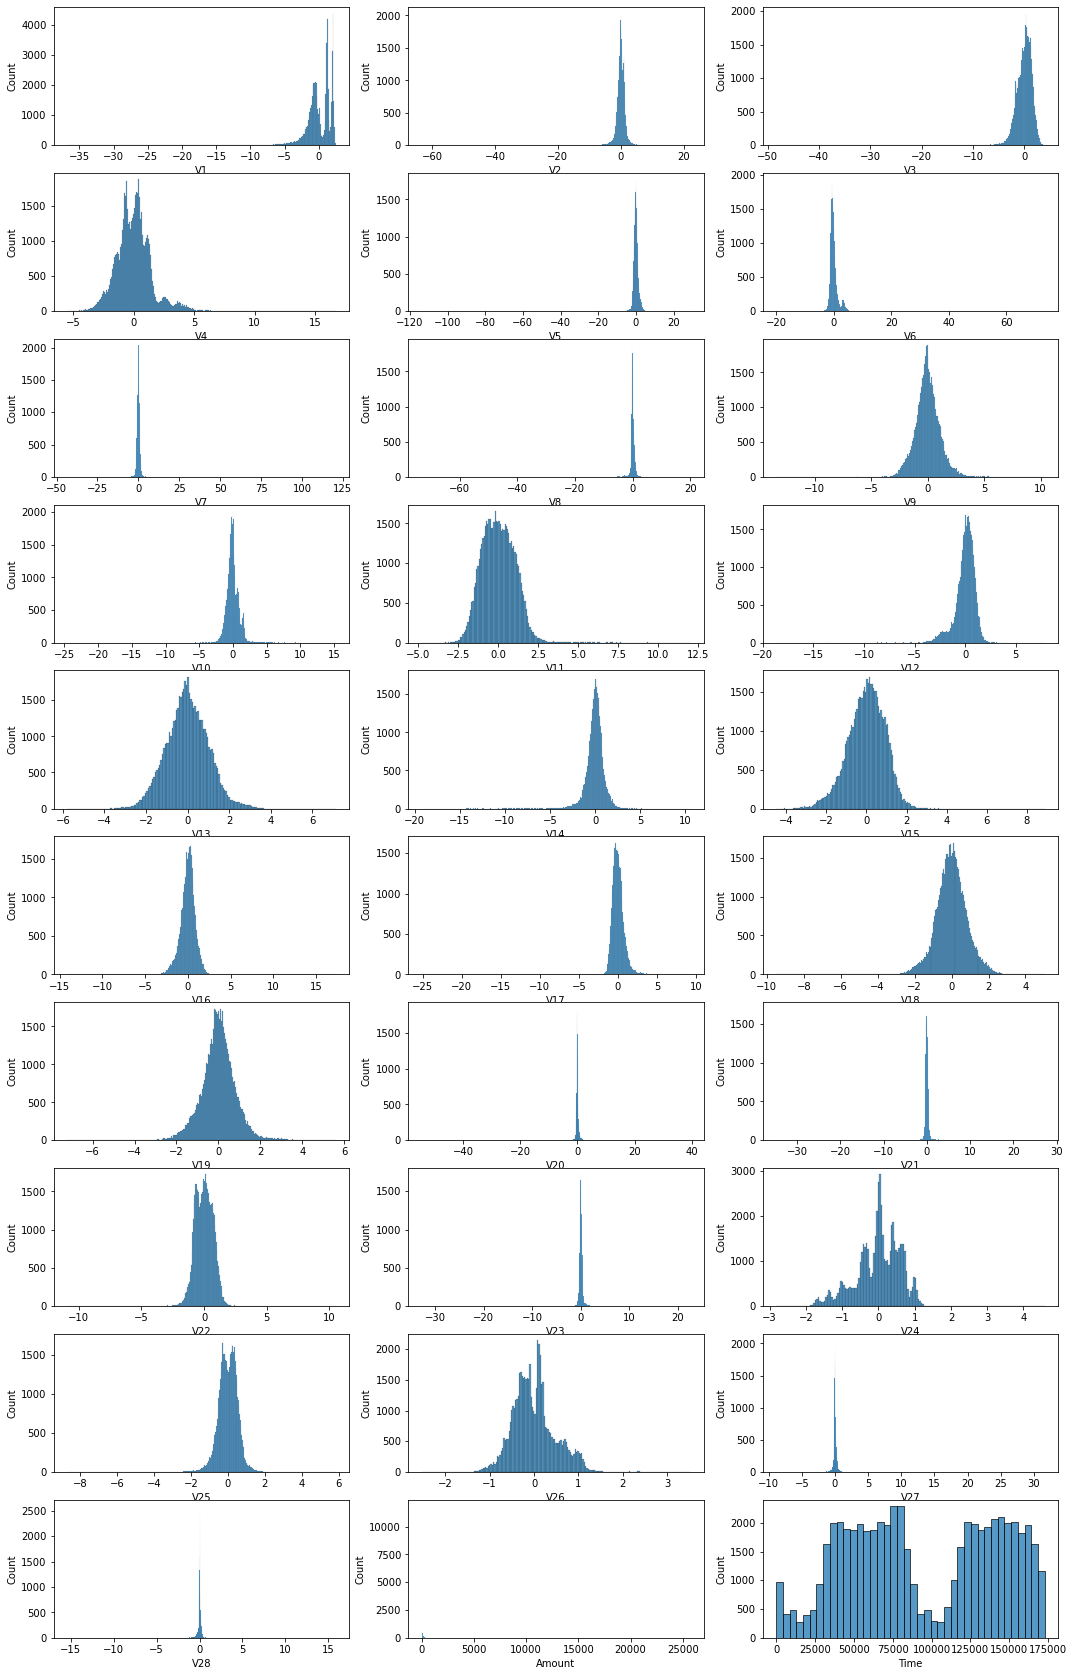

In [17]:
count = 0

fig, ax = plt.subplots(nrows=10, ncols=3,figsize=(18,30))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.histplot(data=credit,x = credit_cols[count],ax=ax[i][j])
        count +=1

Most of the features in our dataset seems to be normally distributed. Meaning the dataset is ready for the scaling process. In short, we don't have to do any outlier handling due to loss of data and any transformation as most of the features in our dataset is normally distributed.

## Feature Scaling: 

Feature Scaling helps us to standarize all the features we have into one scale. It is a standard practise to do as it will remove any kind of abnormality in the dataset. Here, in the dataset, we need to feature scale all the variable except Class which is our target variable. For the feature scaling, we will be using MinMaxScaler method from Sklearn library. 

Before, feature scaling, we will be separating the features and target variable and we will be splitting them into train, validate and test dataset. And then we will apply MixMaxScaler to scale our data. This is done to avoid data leakage.

In [18]:
credit

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
1,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
2,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
3,11,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,...,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50,0
4,12,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,...,0.499625,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,15.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57350,172751,2.085387,-0.033624,-1.706889,-0.015100,0.644669,-0.245303,0.125758,-0.156508,0.277994,...,0.256304,0.862281,-0.063211,0.143339,0.361885,-0.124856,-0.025472,-0.066836,2.27,0
57351,172760,-6.713826,2.369104,-3.534768,-0.368259,-1.721030,-1.322808,-0.190876,0.891149,2.068476,...,0.131247,0.994246,-0.002140,-0.072979,-0.167159,-0.387271,-2.616341,0.474584,19.59,0
57352,172768,-2.076175,2.142238,-2.522704,-1.888063,1.982785,3.732950,-1.217430,-0.536644,0.272867,...,2.016666,-1.588269,0.588482,0.632444,-0.201064,0.199251,0.438657,0.172923,8.95,0
57353,172770,2.007418,-0.280235,-0.208113,0.335261,-0.715798,-0.751373,-0.458972,-0.140140,0.959971,...,-0.208260,-0.430347,0.416765,0.064819,-0.608337,0.268436,-0.028069,-0.041367,3.99,0


In [19]:
X = credit.iloc[:, 0:-1]
y = credit.iloc[:, -1]

In [20]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
1,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67
2,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80
3,11,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,...,-0.153197,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50
4,12,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,...,0.263451,0.499625,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,15.99


In [21]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [22]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=111) 

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.13, stratify=y_trainval, random_state=111)

In [23]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(y), 2))

0.7
0.1
0.2


> 70% data is being used for training purpose, while 10% data is used for validation while 20% data is being used for testing of our model.

In [24]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [25]:
X_train

array([[3.53863518e-01, 9.67045628e-01, 6.52939947e-01, ...,
        2.00635585e-01, 4.93367337e-01, 7.70693110e-05],
       [4.43751809e-01, 9.39746907e-01, 6.67056517e-01, ...,
        2.03956487e-01, 5.02707068e-01, 2.95821598e-05],
       [5.15158882e-01, 8.65735372e-01, 6.62499829e-01, ...,
        1.34790666e-01, 4.73197943e-01, 3.11391156e-03],
       ...,
       [2.09237715e-01, 9.66602675e-01, 6.47339139e-01, ...,
        2.00559233e-01, 4.92973635e-01, 1.98628633e-03],
       [3.76338485e-02, 9.65868989e-01, 6.36357458e-01, ...,
        2.02162682e-01, 4.94276462e-01, 4.32522315e-03],
       [2.51779823e-02, 8.93061987e-01, 6.76958988e-01, ...,
        2.12811321e-01, 4.98899819e-01, 4.25827405e-04]])

## Handling Unbalanced Dataset:

#### Visualize Class Distribution in Train, Val, and Test


In [26]:
def get_class_distribution(obj):
    count_dict = {
        "Fraud": 0,
        "Non_Fraud": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['Non_Fraud'] += 1
        elif i == 1: 
            count_dict['Fraud'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

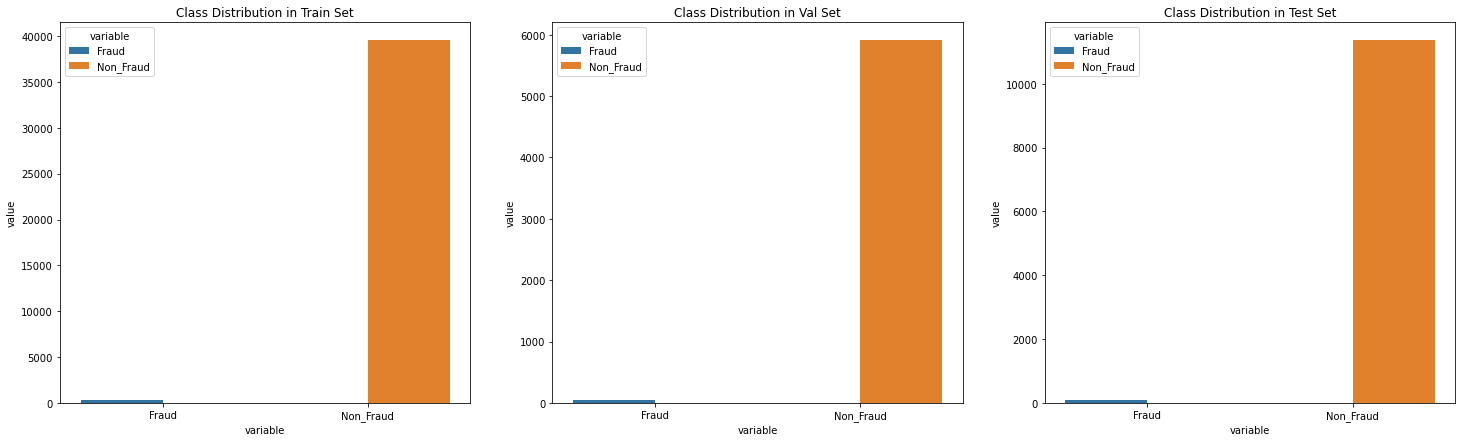

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))

# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')

# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')

# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

Here, we can see that, the fraud class has been equally divided into equal class distribution amoung the datasets. We have successfully handled our imbalanced dataset.

### Devloping Neural Network Model

Here, to build a Neural Network, we will be using the Pytorch library. For that, we need to build a custom dataloader and we also have used weighted sampling process to get the data to the Neural Network. 

In [28]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

### Weighted Sampling

In [29]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [30]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

print(class_weights)

tensor([3.0395e-03, 2.5301e-05])


In [31]:
class_weights_all = class_weights[target_list]

In [32]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

### Necessary Parameters for the DataLoader and Neural Network

In [33]:
EPOCHS = 40
BATCH_SIZE = 50
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 2

In [34]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler)

val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

### Defining a NN Architecture: 

In [35]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

### Using GPU to run the NN

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [37]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)

## Architecture of the NN model

In [38]:
model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=30, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [39]:
# pytorch does not have any way of tracking the accuracy so making a custom accuracy measurement function 

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [40]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

### Training the NN Model

In [41]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        
        
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            
            
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    # print statistics
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.02956 | Val Loss: 0.02698 | Train Acc: 98.752| Val Acc: 99.177
Epoch 002: | Train Loss: 0.00083 | Val Loss: 0.02584 | Train Acc: 99.195| Val Acc: 99.429
Epoch 003: | Train Loss: 0.00055 | Val Loss: 0.02737 | Train Acc: 99.148| Val Acc: 99.345
Epoch 004: | Train Loss: 0.00036 | Val Loss: 0.02390 | Train Acc: 99.301| Val Acc: 99.177
Epoch 005: | Train Loss: 0.00031 | Val Loss: 0.03597 | Train Acc: 99.313| Val Acc: 99.177
Epoch 006: | Train Loss: 0.00031 | Val Loss: 0.02999 | Train Acc: 99.178| Val Acc: 99.177
Epoch 007: | Train Loss: 0.00029 | Val Loss: 0.03079 | Train Acc: 99.258| Val Acc: 99.177
Epoch 008: | Train Loss: 0.00027 | Val Loss: 0.02609 | Train Acc: 99.218| Val Acc: 99.412
Epoch 009: | Train Loss: 0.00028 | Val Loss: 0.02476 | Train Acc: 99.296| Val Acc: 99.631
Epoch 010: | Train Loss: 0.00034 | Val Loss: 0.03108 | Train Acc: 99.368| Val Acc: 99.177
Epoch 011: | Train Loss: 0.00027 | Val Loss: 0.02904 | Train Acc: 99.211| Val Acc: 99.530
Epoch 012:

Here, we can see that, we were able to bring down the train loss and validation loss quite down in each iteration. While the training accuracy and validation accuracy was high in the range of 99.6% range. This might be the case of overfitting or our model is quite good at classifing the class quite accurately. This will be clear in the testing phase of our process. The possibility of overfitting is quite low as we have used both the dropout method and normalization method to prevent it. 

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

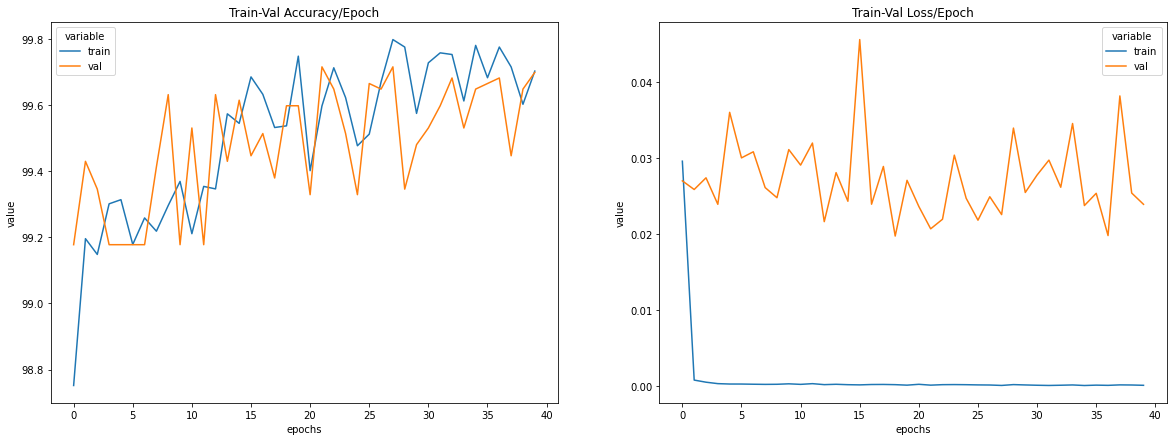

In [42]:
# Results dataframe
train_val_acc = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Visualize dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

The training accuracy and validation accuracy are relatively close to each other and are in the range of 99% meaning our model is quite good at correctly identifying the classes but the train-val loss curve has a huge gap meaning the model might have been overfitting. 

### Testing the Model

In [43]:
y_pred_list = []

with torch.no_grad():
    
    model.eval()
    
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Confusion Matrix to better under the Test Result

<AxesSubplot:>

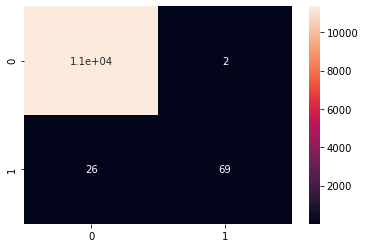

In [44]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))
sns.heatmap(confusion_matrix_df, annot=True)

From the confusion matrix, we can clearly see that, our model was able to accurately classify our 0 label almost most of the time, but was not able to classify 2 of the 0 label. While for the 1 lable which is for fraud, our model was able to identify, 69 times while 26 time it classify it worngly as 1.

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report


accuracy = round(accuracy_score(y_test, y_pred_list), 4)
precision = round(precision_score(y_test, y_pred_list), 4)
recall = round(recall_score(y_test, y_pred_list), 4)

print('Overall Model : Accuracy: {} / Precision: {} / Recall: {} '.format(accuracy,precision,recall))
print("\n")

print(classification_report(y_test, y_pred_list))

Overall Model : Accuracy: 0.9976 / Precision: 0.9718 / Recall: 0.7263 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11358
           1       0.97      0.73      0.83        95

    accuracy                           1.00     11453
   macro avg       0.98      0.86      0.92     11453
weighted avg       1.00      1.00      1.00     11453



We were able to get high overall accuracy and precision from our model but the recall is lagging behind. This is due to miss classification of the label 0 as 1. If we want to increase the recall number, we might have to take a hit in the precision of the model.

Accuracy is the easiest classification metrics to understand. It tells us how many prediction we got right out of total prediction. Here in our test dataset, we got an accuracy of 0.9976. Here, we have like 99.76% change to correctly guess which 2 classes are we predicting.

Precision also called positive predictive value. It tells us if the positive value is predicted then how often is the prediction is correct. It can also be said as measure of quality. It is the number of true positive divided by the total number of elements labelled as being in the positive class. Here, form our model, we got a precision of 0.9718  meaning our model was able to predict positive values 97% of the time correctly.

Recall also know as True Positive Rate or Sensitivity tells us when the actual value is positive how often is the prediction correct. It is a measure of quantity. Recall is calculated by dividing the total number of true positive by the total number of elements that are actually positive class. Here, we got a recall of 0.72 which means our model is very poor at predicting the actual positive values.

### Conclusion:

Our model was able to classify the non-fraudulent case quite nicely with almost 100% accuracy, precison and recall as it has a lot of data to learn with but the same cannot be said for the fraudulent case, as it had very less data to learn with. However, it gave us a high precision with not quite high recall. 

For the financial case, it is really important to detect the fraud cases, which means for the model to work quite right to detect the fraud cases, we need to increase the recall of the model with some hit on precision. Because, classifying the fraud case is much more important than miss classifying the non-fraud cases as fraud.